In [12]:
# generate some data -- random log p-value-ish things, about 150-200 of them
# nothing special about the following formula for data generation
my_data <- rexp(10^4)
my_data <- log(1/(exp(my_data[my_data > 4]))^2)

# our sample (eg master regulator tfs) is 17 of them all from the top half
my_sample <- sample(head(sort(my_data),length(my_data)/2), 17, replace=FALSE)

# our statistic is the mean of the data points in our sample
my_mean <- mean(my_sample)

In [13]:
# build a null distribution of what the mean of 17 data points usually looks like
# can swap out stat_func for median or whatever

build_stat_dist <- function(data, set_size=17, stat_func=mean, n_boot=1000, replace=FALSE) {
    
    stat_vec <- sapply(
                    1:n_boot,
                    function(x) stat_func(sample(data, set_size, replace=replace))
                )
                        
    return(stat_vec)
}

In [14]:
# this takes half a minute for 10^6 bootstrap samples, maybe sapply isn't so fast after all
# bootsrrapping parallelizes perfectly, worth thinking about if needed

dist_out <- build_stat_dist(my_data, n_boot=10^6)

In [15]:
# use the info in the histogram object to compute the area under the (normalized) curve
# to the left of our value -- obv switch to the right tail if our stat value is greater
# than the mean, but for log p-vals, left is rarer

get_p_value <- function(some_mean, some_distribution, which_tail="left") {
    
    h <- hist(some_distribution, plot=FALSE)
    grid <- h$mids
    
    stopifnot(which_tail %in% c("left", "right"))
    if (which_tail=="left") {
        my_region <- grid[grid < some_mean]
    } else {
        my_region <- grid[grid > some_mean]
    } 
    
    my_inds <- match(my_region, grid)
    my_area <- sum(h$density[my_inds])
    my_prob <- my_area/sum(h$density)
    
    return(my_prob)

}

In [16]:
# my_prob should be the probability of geting our mean -- or an even more extremal value --
# given the bootstrapped null distribution we generated from random sets of the same size

get_p_value(my_mean, dist_out)

[1] 0.005111

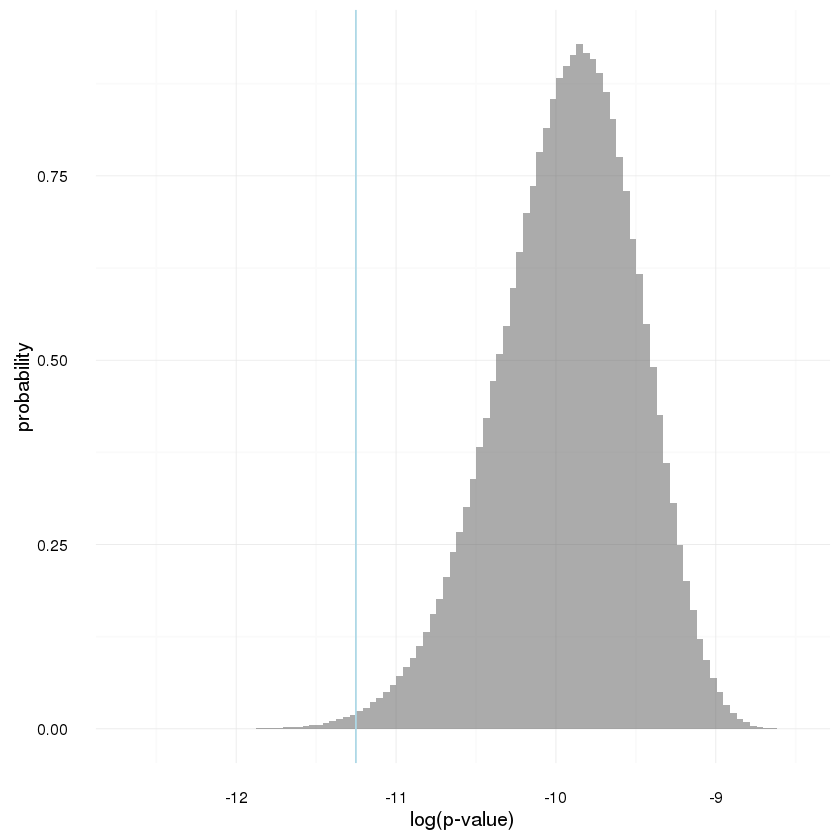

In [17]:
# see what our distribution looks like
# should be relatively smooth or we probably need more samples in generating it

library(ggplot2)

ggplot(as.data.frame(dist_out)) + 
geom_histogram(aes(x=dist_out, y=..density..), bins=100, alpha=0.5) +
geom_vline(xintercept=my_mean, colour="lightblue") +
labs(x="log(p-value)", y="probability") +
theme_minimal()